In [1]:
import spatialmath as sm
import spatialgeometry as sg
import roboticstoolbox as rtb
from pydrake.solvers import MathematicalProgram, Solve
import swift
import time
import numpy as np


def jacobian_i_k_optimisation(robot, v, v_max=1.2):
    # jacobian inverse kinematics with optimisation
    J = robot.jacobe(robot.q)
    prog = MathematicalProgram()
    v_opt = prog.NewContinuousVariables(6, "v_opt")
    # Define the error term for the cost function
    error = J @ v_opt - v
    prog.AddCost(error.dot(error))
    # Add bounding box constraint for joint velocities
    lower_bounds = [-v_max] * 6  # Lower bounds for each joint velocity
    upper_bounds = [v_max] * 6   # Upper bounds for each joint velocity
    prog.AddBoundingBoxConstraint(lower_bounds, upper_bounds, v_opt)
    # Solve the optimization problem
    result = Solve(prog)
    return result.is_success(), result.GetSolution(v_opt)

def end_effector_base_position_from_tip(T_tip ,offset):
    """
    Calculate the end effector base position given the tip position and an arbitrary offset.
    
    :param tip_position: A tuple of (x, y, z) coordinates for the end effector tip.
    :param tip_orientation: A tuple of (roll, pitch, yaw) angles in degrees for the end effector tip orientation.
    :param offset: A tuple of (x_e, y_e, z_e, roll_e, pitch_e, yaw_e) representing the offset of the base from the tip.
    :return: The position of the end effector base as a tuple (x, y, z).
    """
    x_e, y_e, z_e, roll_e, pitch_e, yaw_e = offset
    T_offset = sm.SE3.RPY([roll_e, pitch_e, yaw_e], unit='deg') * sm.SE3(x_e, y_e, z_e)
    
    # Calculate the transformation matrix for the base
    T_base = T_tip * T_offset.inv()
    return T_base

def generate_circular_trajectory(T0, r, n_points=100):
    """
    Generates a circular trajectory in 3D space.
    
    :param T0: Initial pose as an SE3 object.
    :param r: Radius of the circle.
    :param n_points: Number of points to generate along the circle.
    :return: A list of SE3 objects representing poses along the circular trajectory.
    """
    # Angle increments for generating points on the circle
    theta = np.linspace(0, 2 * np.pi, n_points, endpoint=False)
    
    # Circle parameterization in its local XY plane
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    z = np.zeros_like(x)  # Assuming the circle lies in the XY plane
    
    # Generate poses along the circular trajectory
    trajectory = []
    for xi, yi, zi in zip(x, y, z):
        # Construct the translation vector in the local frame of T0
        local_translation = sm.SE3(xi, yi, zi)
        
        # Transform to the global frame using T0
        global_pose = T0 * local_translation
        
        # Append the global pose to the trajectory
        trajectory.append(global_pose)
    
    return trajectory


In [5]:
class Lite6:
    def __init__(self, simulation, robot_ip = None, tcp_offset = None) -> None:
        self.virtual_robot = rtb.models.URDF.Lite6()
        self.simulation = simulation
        if self.simulation:
            self.simulation.add(self.virtual_robot, robot_alpha=True, collision_alpha=False)
        self.tcp_offset = tcp_offset
        self.real_robot = None
        if robot_ip:
            from xarm.wrapper import XArmAPI
            from robot import RobotMain
            self.real_robot = RobotMain(XArmAPI(robot_ip, baud_checkset=False))
            print(self.real_robot)

    def move_to(self, dest, dt=0.05, gain=1, treshold=0.01):
        if self.tcp_offset:
            dest = end_effector_base_position_from_tip(dest, self.tcp_offset)
        if self.simulation:
            axes = sg.Axes(length=0.1, pose=dest)
            self.simulation.add(axes)
        if self.real_robot:
            self.real_robot._arm.set_mode(4)
            self.real_robot._arm.set_state(0)
        arrived = False
        while not arrived:
            v, arrived = rtb.p_servo(self.virtual_robot.fkine(self.virtual_robot.q), dest, gain=gain, threshold=treshold)
            qd = jacobian_i_k_optimisation(self.virtual_robot, v, v_max=1)[1]
            self.virtual_robot.qd = qd
            if self.real_robot:
                self.real_robot._arm.vc_set_joint_velocity(qd, is_radian=True)
            if self.simulation:
                self.simulation.step(dt)
        if self.real_robot:
            self.real_robot._arm.vc_set_joint_velocity([0, 0, 0, 0, 0, 0], is_radian=True)
        return arrived, self.virtual_robot.q

    def move_line(self, q0, T1):
        t = np.arange(0, 2, 0.05)
        T0 = self.virtual_robot.fkine(q0)
        if self.tcp_offset:
            T0 = end_effector_base_position_from_tip(T0, lite6.tcp_offset)
            T1 = end_effector_base_position_from_tip(T1, lite6.tcp_offset)
        if self.real_robot:
            self.real_robot._arm.set_mode(1)
            self.real_robot._arm.set_state(0)
        Ts = rtb.ctraj(T0, T1, t)
        Js = self.virtual_robot.ikine_LM(Ts, mask=[1, 1, 1, 0.1, 0.1, 0.1], q0=q0)
        for q in Js.q:
            if self.simulation:
                self.virtual_robot.q = q
                self.simulation.step(0.1)
            if self.real_robot:
                self.real_robot._arm.set_servo_angle_j(q, is_radian=True)
                time.sleep(0.1)
        return True

    
    def get_pose(self):
        return self.virtual_robot.fkine(self.virtual_robot.q)
    
    def reset(self):
        self.real_robot._reset()
        self.virtual_robot.q = self.virtual_robot.qz
        self.simulation.step(0.1)


tcp_offset = [0, 0, 0.2, 0, 0, 0]
sim = swift.Swift()
sim.launch(realtime=True)
lite6 = Lite6(simulation=sim, robot_ip="192.168.1.159",  tcp_offset=tcp_offset)
#lite6 = Lite6(simulation=sim,  tcp_offset=tcp_offset)

ROBOT_IP: 192.168.1.159, VERSION: v1.12.2, PROTOCOL: V1, DETAIL: 6,9,LI1006,DL1000,v1.12.2, TYPE1300: [0, 0]
change protocol identifier to 3
[clean_error], xArm is ready to move


In [6]:

lite6.reset()
T0 = sm.SE3(0.1, 0.1, 0)*sm.SE3.RPY([-180, -180, 0], order='xyz', unit='deg')
T1 = sm.SE3(0.1, 0.08, 0)*sm.SE3.RPY([-180, -180, 0], order='xyz', unit='deg')
_, q0 = lite6.move_to(T0)
print(q0)
lite6.move_line(q0,T1)

[SDK][WARNING][2024-04-10 10:01:12][base.py:1991] - - The mode may be incorrect, just as a reminder, mode: 4 (0)
[SDK][WARNING][2024-04-10 10:01:12][base.py:1991] - - The mode may be incorrect, just as a reminder, mode: 4 (0)
[ 7.60552685e-01 -1.24788249e-01  2.35881609e-01  1.99698840e-04
  3.60597650e-01  7.60376031e-01]
ControllerError, code: 24
ControllerError, code: 24
[2024-04-10 10:01:15][81] err=24, quit
ControllerError, code: 24
[2024-04-10 10:01:15][81] err=24, quit
[2024-04-10 10:01:15][81] err=24, quit
[SDK][ERROR][2024-04-10 10:01:15][base.py:373] - - API -> set_servo_angle_j -> code=1, angles=[0.7599750334813837, -0.5404709125690887, 0.8449066741578322, 7.592811461787363e-05, 1.3853057561140387, 0.7599730254714081, 0], velo=0.3490658503988659, acc=8.726646259971648
[SDK][ERROR][2024-04-10 10:01:15][base.py:373] - - API -> set_servo_angle_j -> code=1, angles=[0.7593815352728903, -0.5422020760244561, 0.8378338673590169, 7.548994968153977e-05, 1.3799646360687872, 0.759379228

True

ControllerError had clean
ControllerError had clean
[2024-04-10 10:01:32][88] state=4, quit
[2024-04-10 10:01:32][88] state=4, quit
ControllerError had clean
[2024-04-10 10:01:32][88] state=4, quit


IKSolution: q=[[0.7854, -0.1149, 0.2604, -3.142, -0.3753, -2.356],
 [0.7848, -0.1154, 0.26, -3.142, -0.3754, -2.357],
 [0.7829, -0.1169, 0.2587, -3.142, -0.3756, -2.359],
 [0.7798, -0.1195, 0.2565, -3.142, -0.3759, -2.362],
 [0.7753, -0.123, 0.2534, -3.142, -0.3765, -2.366],
 [0.7696, -0.1276, 0.2496, -3.142, -0.3772, -2.372],
 [0.7625, -0.1332, 0.2449, -3.142, -0.378, -2.379],
 [0.7542, -0.1396, 0.2395, -3.142, -0.3791, -2.387],
 [0.7457, -0.146, 0.2342, -3.142, -0.3802, -2.396],
 [0.7372, -0.1524, 0.2289, -3.142, -0.3814, -2.404],
 [0.7284, -0.1589, 0.2237, -3.142, -0.3826, -2.413],
 [0.7196, -0.1653, 0.2185, -3.142, -0.3838, -2.422],
 [0.7106, -0.1717, 0.2134, -3.142, -0.3851, -2.431],
 [0.7015, -0.178, 0.2084, -3.142, -0.3864, -2.44],
 [0.6935, -0.1836, 0.204, -3.142, -0.3876, -2.448],
 [0.6868, -0.1881, 0.2005, -3.142, -0.3887, -2.455],
 [0.6815, -0.1917, 0.1978, -3.142, -0.3895, -2.46],
 [0.6778, -0.1942, 0.1958, -3.142, -0.39, -2.464],
 [0.6755, -0.1957, 0.1947, -3.142, -0.3904,

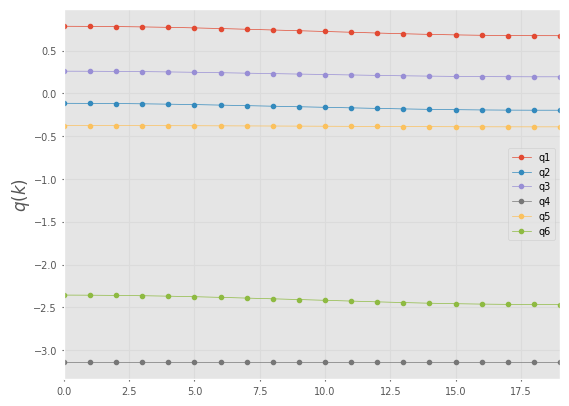

In [5]:

T0 = sm.SE3(0.1, 0.1, 0)*sm.SE3.RPY([-180, -180, 0], order='xyz', unit='deg')
T1 = sm.SE3(0.1, 0.08, 0)*sm.SE3.RPY([-180, -180, 0], order='xyz', unit='deg')
if lite6.tcp_offset:
    T0 = end_effector_base_position_from_tip(T0, lite6.tcp_offset)
    T1 = end_effector_base_position_from_tip(T1, lite6.tcp_offset)
t = np.arange(0, 2, 0.10)

Ts = rtb.ctraj(T0, T1, t)
sol = lite6.virtual_robot.ikine_LM(Ts, mask=[1, 1, 1, 0.1, 0.1, 0.1])
print(sol)

for q in sol.q:

    lite6.virtual_robot.q = q
    
    sim.step(0.1)
    time.sleep(0.1)

traj = rtb.mstraj(sol.q, 1.0, 1.0, qdmax=1)
traj.plot()
        

In [7]:
def generate_circular_trajectory(T0, r, n_points=100):
    """
    Generates a circular trajectory in 3D space.
    
    :param T0: Initial pose as an SE3 object.
    :param r: Radius of the circle.
    :param n_points: Number of points to generate along the circle.
    :return: A list of SE3 objects representing poses along the circular trajectory.
    """
    # Angle increments for generating points on the circle
    t = np.linspace(0, 1,  n_points, endpoint=False)
    theta = np.linspace(0, 2 * np.pi, n_points, endpoint=False)
    
    # Circle parameterization in its local XY plane
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    z = np.zeros_like(x)  # Assuming the circle lies in the XY plane
    
    # Generate poses along the circular trajectory
    trajectory = []
    for i, (xi, yi, zi) in enumerate(zip(x, y, z)):
        # Construct the translation vector in the local frame of T0
        local_translation = sm.SE3(xi, yi, zi)
        
        # Transform to the global frame using T0
        global_translation = T0 * local_translation

        
        # Append the global pose to the trajectory
        trajectory.append(global_translation)
    #return rtb.tools.trajectory.Trajectory("circle", trajectory, t)
    return trajectory


traj = generate_circular_trajectory(T0, 0.01)
for to in traj:
    lite6.virtual_robot.q = lite6.virtual_robot.ikine_LM(to, mask=[1, 1, 1, 0.1, 0.1, 0.1], q0=q0).q
    sim.step(0.1)
    
#sol = lite6.virtual_robot.ikine_LM(traj, mask=[1, 1, 1, 0.1, 0.1, 0.1], q0=q0)